License: BSD
Author: Sasank Chilamkurthy
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [1]:
import copy
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

In [2]:
!ls ../..
DATA_DIR = '../../data/hymenoptera_data'
IMG_MEANS = [0.485, 0.456, 0.406]
IMG_SDS = [0.229, 0.224, 0.225]

data      tutorials


In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(IMG_MEANS, IMG_SDS)]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(IMG_MEANS, IMG_SDS)])}

In [4]:
image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x), 
                                          data_transforms[x])
                  for x in ['train', 'val']}

In [5]:
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
    for x in ['train', 'val']}

In [6]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [8]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(IMG_MEANS)
    std = np.array(IMG_SDS)
    inp = std*inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.pause(0.001)

In [9]:
inputs, classes = next(iter(dataloaders['train']))

In [10]:
out = torchvision.utils.make_grid(inputs)

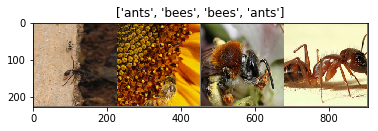

In [11]:
imshow(out, title=[class_names[x] for x in classes])

# Training the Model

In [12]:
def train_model(model, criterion, optimizer, scheduler, epochs=25):
    since = time.time()
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch + 1, epochs))
        print('-' * 25)
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train() # set to training mode
            else:
                model.eval()  # ''  ''  eval    ''
            running_loss = 0.
            running_correct = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, labels)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * input.size(0)
                running_correct += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('  {} Loss: {:.4f}\tAcc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deeepcopy(model.state_dict())
        print()
    time_elapsed = time.time - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))
    model.load_state_dict(best_model_weights)
    return model

# Visualizing Model Performance

In [13]:
def visualize_model(model, n_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(n_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == n_images:
                    model.train(mode=was.training)
                    return
        model.train(mode=was.training)

# Fine Tuning